u0_train.shape =  (5000, 16384)
type of u0_train =  <class 'numpy.ndarray'>
u0_testing.shape =  (1000, 16384)
s_train.shape =  (5000, 16384)
s_testing.shape =  (1000, 16384)
xy_train_testing.shape (16384, 2)
Epoch 1 took 0.49s, loss: 7.7253e-03, val_loss: 6.1680e-03, 
Epoch 2 took 0.40s, loss: 5.8268e-03, val_loss: 4.6748e-03, 
Epoch 3 took 0.41s, loss: 4.1737e-03, val_loss: 4.4915e-03, 
Epoch 4 took 0.40s, loss: 2.6896e-03, val_loss: 2.4179e-03, 
Epoch 5 took 0.41s, loss: 2.3513e-03, val_loss: 2.3140e-03, 
Epoch 6 took 0.41s, loss: 2.2393e-03, val_loss: 2.3270e-03, 
Epoch 7 took 0.41s, loss: 2.1713e-03, val_loss: 2.1589e-03, 
Epoch 8 took 0.40s, loss: 1.9897e-03, val_loss: 1.9182e-03, 
Epoch 9 took 0.41s, loss: 1.6498e-03, val_loss: 1.9665e-03, 
Epoch 10 took 0.41s, loss: 1.5740e-03, val_loss: 1.1953e-03, 
Epoch 11 took 0.43s, loss: 1.1526e-03, val_loss: 1.2398e-03, 
Epoch 12 took 0.42s, loss: 1.0890e-03, val_loss: 1.0116e-03, 
Epoch 13 took 0.41s, loss: 9.0869e-04, val_loss: 8.8022e-

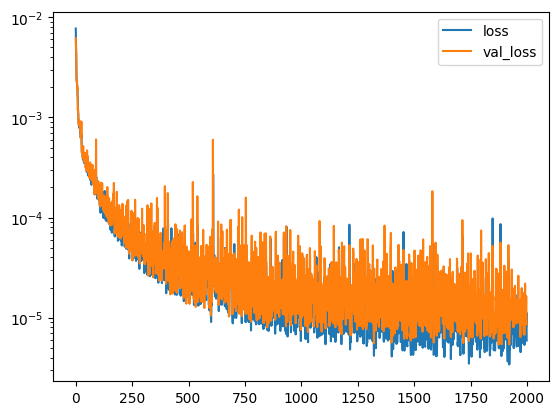

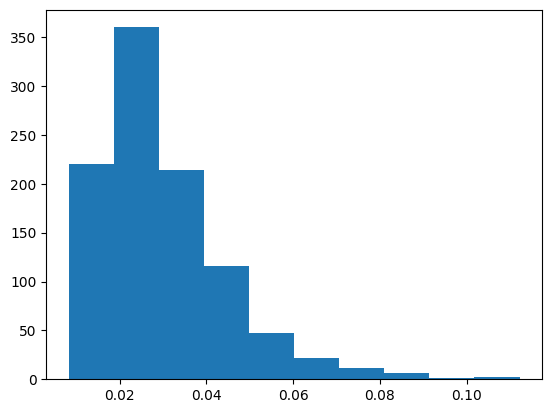

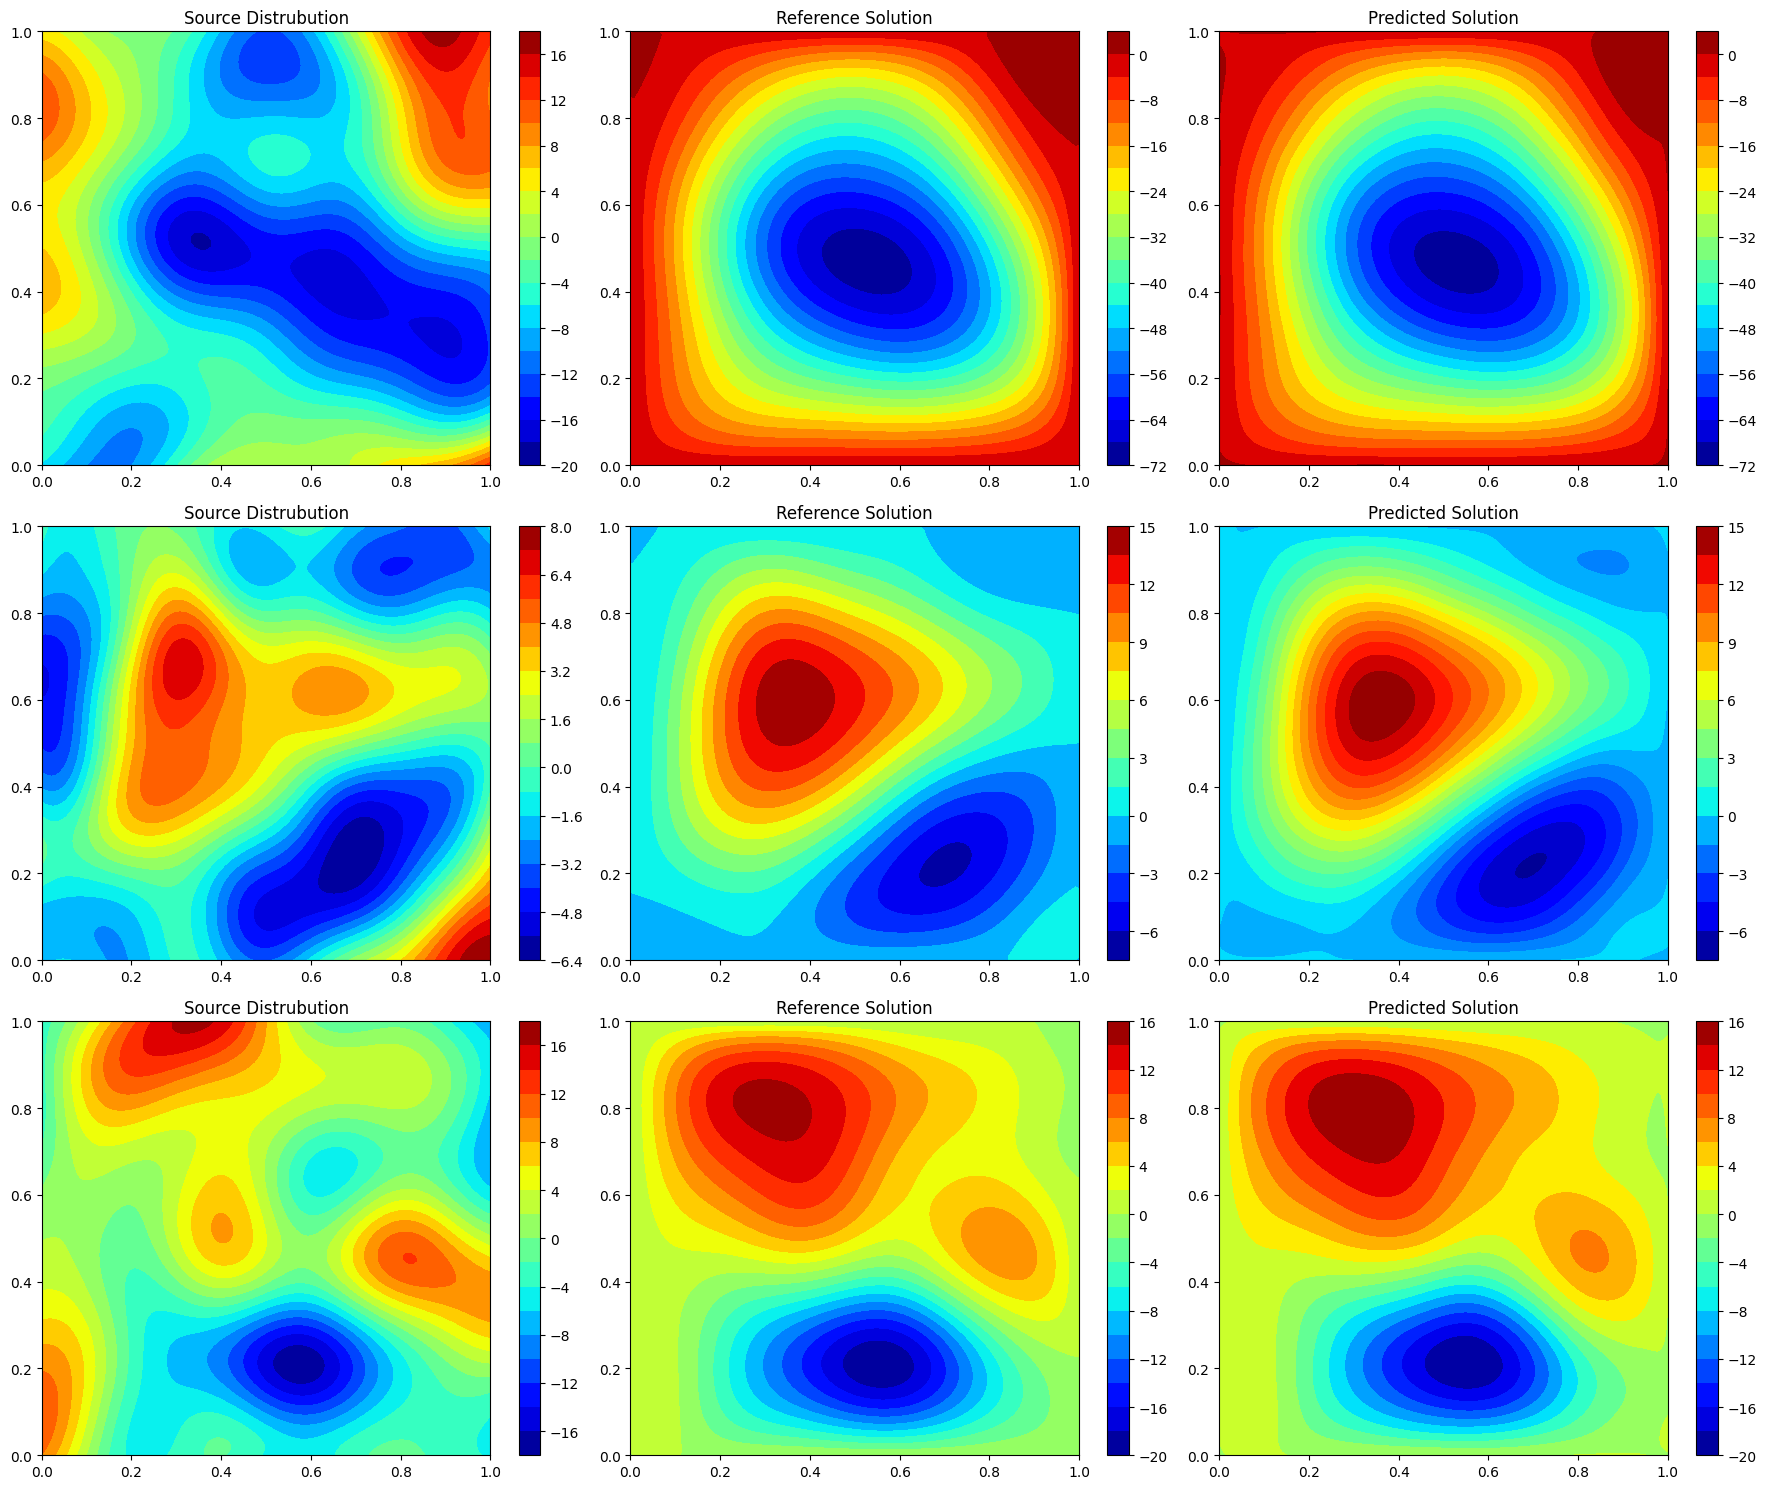

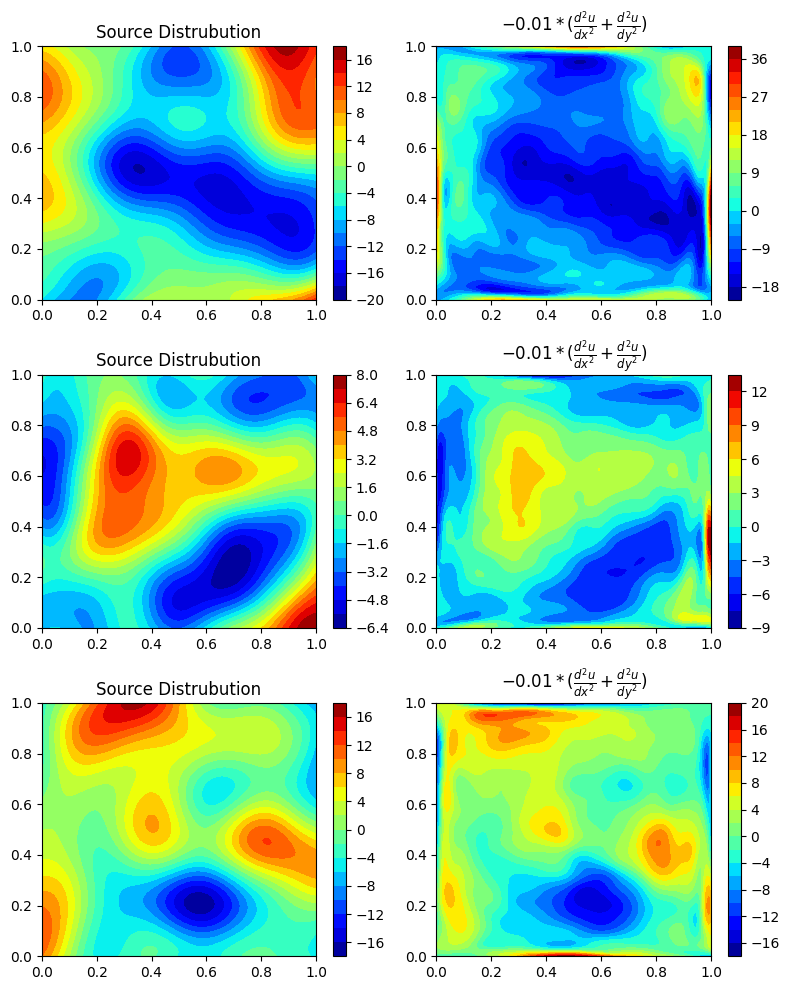

In [1]:
%run myddm-deeponet.py


y_pred.shape = (5000, 16384)
Index for minimum element: 2645
Index for maximum element: 1430
Index for median element: 2803


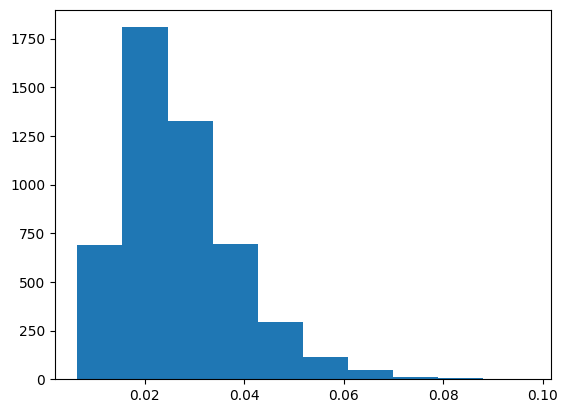

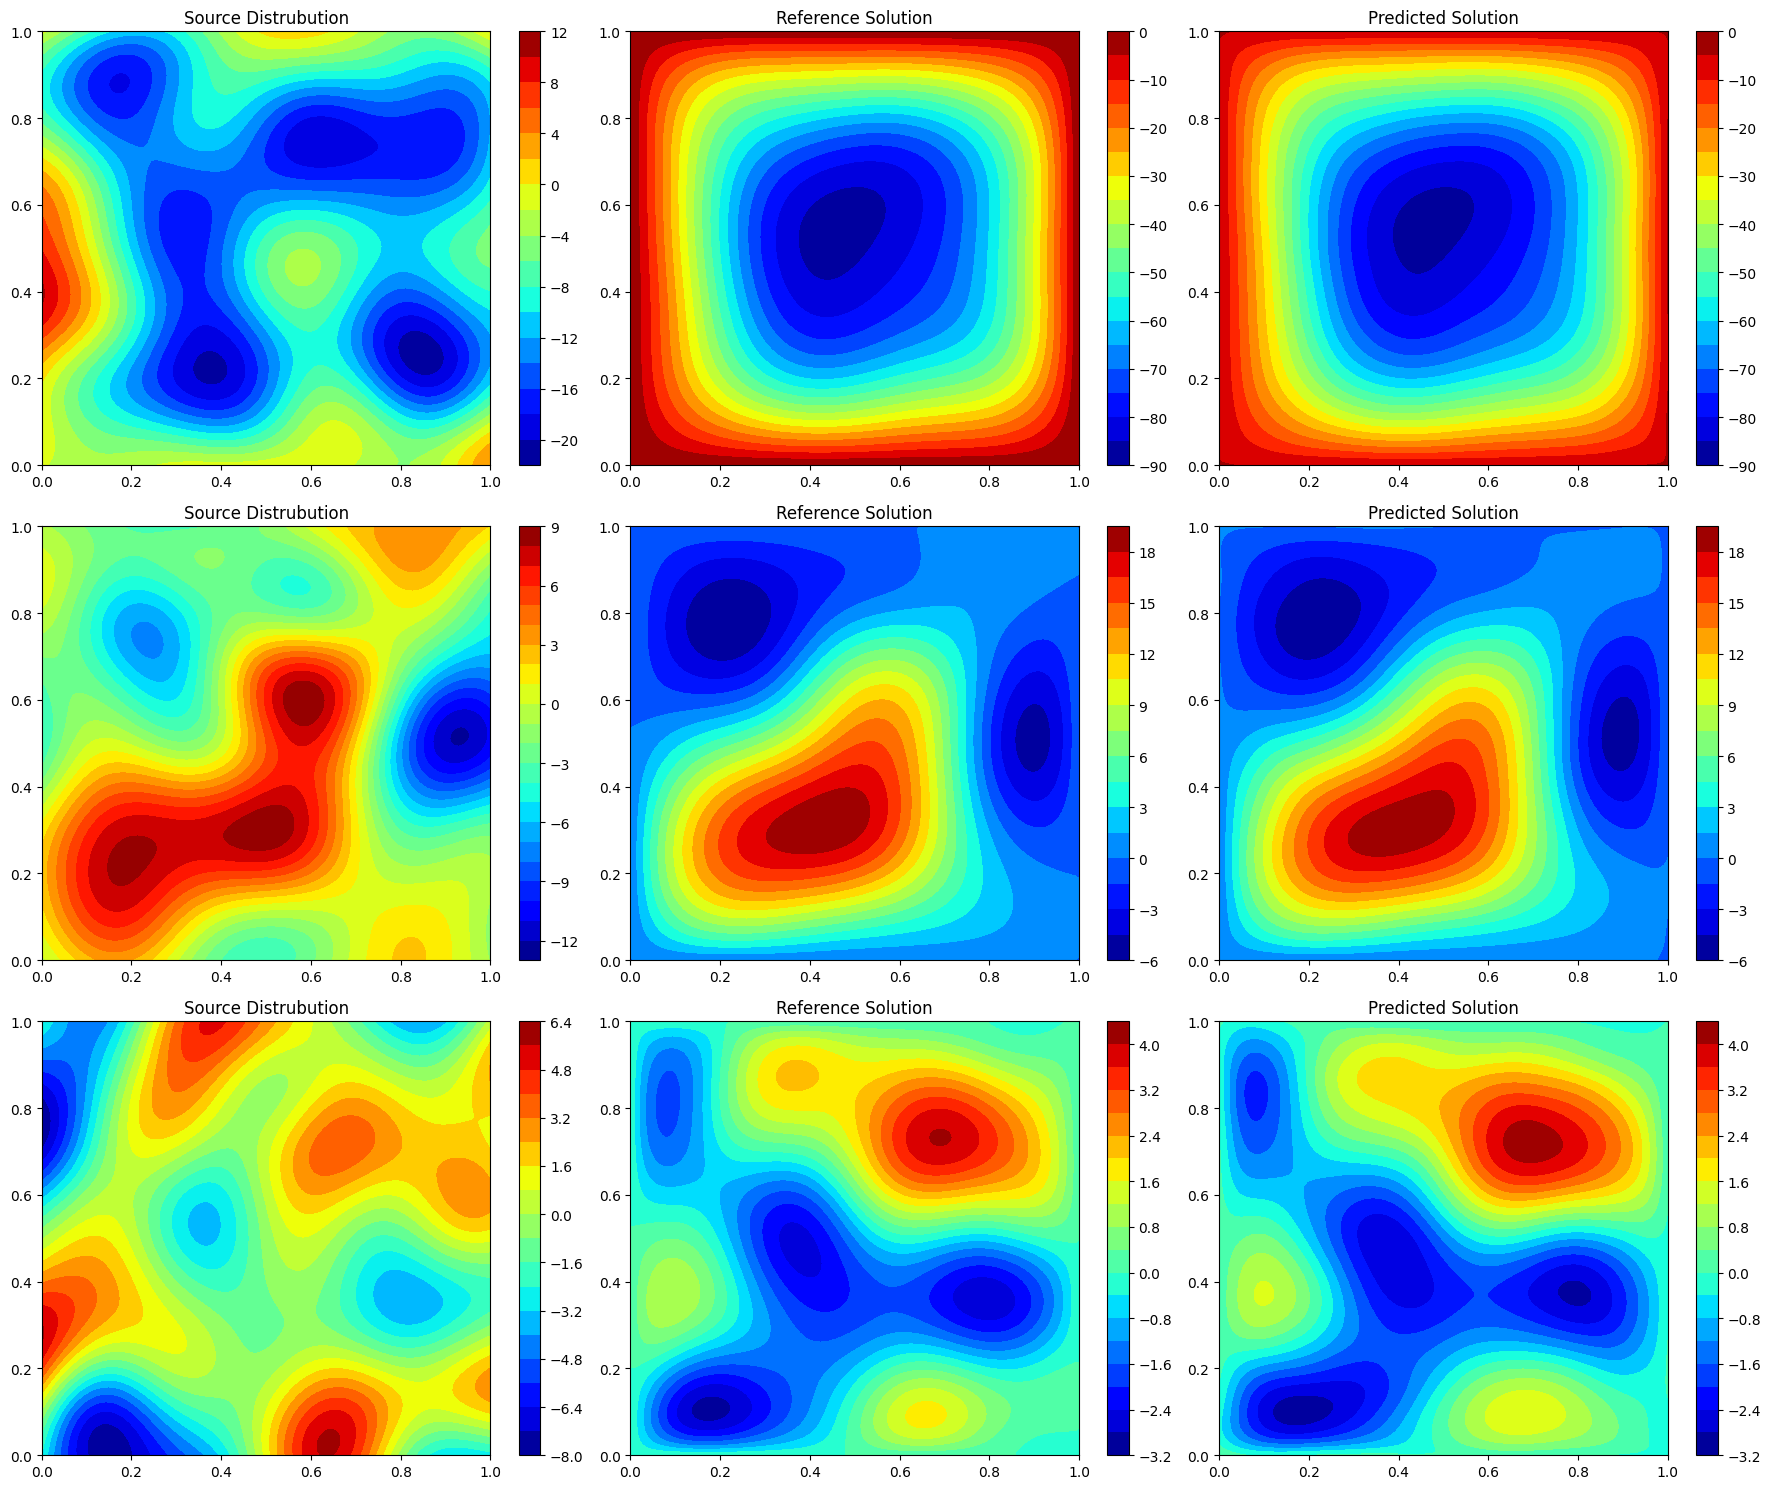

In [2]:

y_pred_p = model.predict(x_train, device)
y_pred = scaler_solution * y_pred_p
y_test = s_train_raw
print("y_pred.shape =", y_pred.shape)


# %%


# %%

error_s = []
for i in range(len(y_test)):
    error_s_tmp = np.linalg.norm(y_test[i] - y_pred[i]) / np.linalg.norm(y_test[i])
    error_s.append(error_s_tmp)
error_s = np.stack(error_s)
fig = plt.figure()
_ = plt.hist(error_s)


# %%




# %%
sort_idx = np.argsort(error_s)
min_index = sort_idx[0]
max_index = sort_idx[-1]
median_index = sort_idx[len(sort_idx) // 2]

# Print the indexes
print("Index for minimum element:", min_index)
print("Index for maximum element:", max_index)
print("Index for median element:", median_index)


min_median_max_index = np.array([min_index, median_index, max_index])

nr, nc = 3, 3
fig = plt.figure(figsize=(18, 15))
for i, index in enumerate(min_median_max_index):

    u0_testing_nx_ny = u0_train_raw[index].reshape(Ny, Nx)
    s_testing_nx_ny = y_test[index].reshape(Ny, Nx)
    s_pred_nx_ny = y_pred[index].reshape(Ny, Nx)
    vmin = min(s_testing_nx_ny.min(), s_pred_nx_ny.min())
    vmax = max(s_testing_nx_ny.max(), s_pred_nx_ny.max())

    ax = plt.subplot(nr, nc, nc * i + 1)
    # py.figure(figsize = (14,7))
    c = ax.contourf(x_grid, y_grid, u0_testing_nx_ny, 20, cmap="jet")
    ax.set_title(r"Source Distrubution")
    plt.colorbar(c)
    plt.tight_layout()
    ax = plt.subplot(nr, nc, nc * i + 2)
    # py.figure(figsize = (14,7))
    c1 = ax.contourf(x_grid, y_grid, s_testing_nx_ny, 20, cmap="jet")
    ax.set_title(r"Reference Solution")
    cbar = fig.colorbar(c1, ax=ax)
    plt.tight_layout()
    ax = plt.subplot(nr, nc, nc * i + 3)
    # py.figure(figsize = (14,7))
    c2 = ax.contourf(x_grid, y_grid, s_pred_nx_ny, 20, cmap="jet")
    ax.set_title(r"Predicted Solution")
    cbar = fig.colorbar(c1, ax=ax)
    plt.tight_layout()

    # if index == min_index:
    #     plt.savefig("temperature_min_error_5000_3.jpg", dpi=300)
    # if index == median_index:
    #     plt.savefig("temperature_median_error_5000_3.jpg", dpi=300)
    # if index == max_index:
    #     plt.savefig("temperature_max_error_5000_3.jpg", dpi=300)
    # plt.savefig("temperature_sample{}_5000_3.jpg".format(index), dpi=300)
    # plt.show()



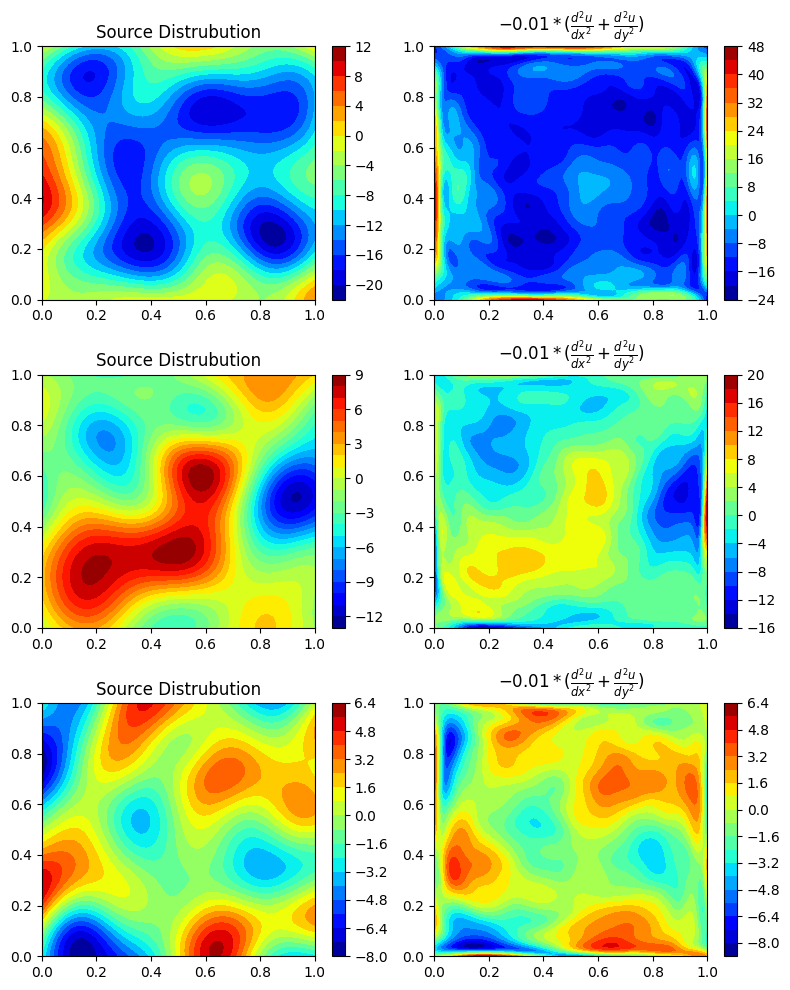

In [3]:


# %%
def LaplaceOperator2D(x, y,aux=None):
    dy_dx = torch.autograd.grad(
        outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]
    dydx, dydy = dy_dx[:, 0:1], dy_dx[:, 1:2]
    dydx2 = torch.autograd.grad(
        dydx,
        x,
        grad_outputs=torch.ones_like(dydx),
        create_graph=True,
    )[0][:, 0:1]
    dydy2 = torch.autograd.grad(
        dydy, x, grad_outputs=torch.ones_like(dydy), create_graph=True
    )[0][:, 1:2]

    return -0.01 * (dydx2 + dydy2) * scaler_solution

# import dde
# def LaplaceOperator2D(x, y,aux=None):
#     dydx2 = dde.grad.hessian(y, x, i=0, j=0)
#     dydy2 = dde.grad.hessian(y, x, i=1, j=1)
#     return -0.01 *(dydx2 + dydy2)*scaler_solution
# %%
laplace_op = DeepONet.EvaluateDeepONetPDEs(model, LaplaceOperator2D)

# %%
x_plot=x_train
u0_plot_raw=u0_train_raw

input_branch, input_trunk = x_plot[0], x_plot[1]
input_branch = torch.tensor(input_branch).to(device)
input_trunk = torch.tensor(input_trunk,requires_grad=True).to(device)
output = model((input_branch, input_trunk))


laplace_op_val = laplace_op((input_branch[[min_median_max_index]], input_trunk))
laplace_op_val=laplace_op_val.detach().cpu().numpy()
# %%
nr, nc = 3, 2
i = 0
fig = plt.figure(figsize=(8, 10))

for i, index in enumerate(min_median_max_index):

    vmin = np.min(u0_plot_raw[index])
    vmax = np.max(u0_plot_raw[index])

    ax = plt.subplot(nr, nc, nc * i + 1)
    # py.figure(figsize = (14,7))
    c1 = ax.contourf(
        x_grid, y_grid, u0_plot_raw[index].reshape(Ny, Nx), 20, cmap="jet"
    )
    ax.set_title(r"Source Distrubution")
    cbar = fig.colorbar(c1, ax=ax)
    plt.tight_layout()
    ax = plt.subplot(nr, nc, nc * i + 2)
    # py.figure(figsize = (14,7))
    c2 = ax.contourf(x_grid, y_grid, laplace_op_val[i].reshape(Ny, Nx), 20, cmap="jet")
    ax.set_title(r"$-0.01*(\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$")
    cbar = fig.colorbar(c2, ax=ax)
    plt.tight_layout()

